In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from prophet import Prophet
from matplotlib import pyplot

In [2]:
start = '2020-10-01'                # format: YYYY-MM-DD
end = dt.datetime.now()             # today

In [3]:
stock='AAPL'
df = yf.download(stock,start, end, interval='1d')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-01,117.639999,117.720001,115.830002,116.790001,115.557297,116120400
2020-10-02,112.889999,115.370003,112.220001,113.019997,111.827065,144712000
2020-10-05,113.910004,116.650002,113.550003,116.500000,115.270332,106243800
2020-10-06,115.699997,116.120003,112.250000,113.160004,111.965607,161498200
2020-10-07,114.620003,115.550003,114.129997,115.080002,113.865341,96849000


In [4]:
short_sma= 20
long_sma = 50
SMAs=[short_sma, long_sma]

In [5]:
for i in SMAs:
    df["SMA_"+str(i)]= df.iloc[:,4].rolling(window=i).mean()

In [6]:
# Adding volume moving average column
Volume_MA = 10
#for i in Volume_MA:
df["Vol_Avg"]= df.iloc[:,5].rolling(window=Volume_MA).mean()

In [7]:
# Adding Moving average indicator
Volume_MAI = 0
#for i in Volume_MA:
df["Vol_Avg_Ind"]= df.iloc[:,5]/df.iloc[:,8]#.rolling(window=Volume_MA).mean()

In [8]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,Vol_Avg,Vol_Avg_Ind
Date,,,,,,,,,,
2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800,157.154407,163.094894,121647120.0,0.712255
2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300,156.258687,162.898369,120584100.0,0.649640
2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900,154.950455,162.570588,120732740.0,0.908974
2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600,153.509163,162.063370,121289770.0,1.122070
2022-05-20,139.089996,140.699997,132.610001,137.589996,137.589996,137194600,152.311031,161.649421,123403660.0,1.111755


# Start Prophet with regressor

In [9]:
fit_df = pd.DataFrame()
fit_df[['Close', 'Vol_Avg_Ind']] = df[['Close', 'Vol_Avg_Ind']]
fit_df = fit_df[['Close', 'Vol_Avg_Ind']].dropna()

fit_df.index = pd.to_datetime(fit_df.index)
fit_df.reset_index(inplace=True)
#fit_df.index.names = ['ds']
fit_df.columns = ['ds','y', 'Vol_Avg_Ind']

fit_df.tail(5)

,ds,y,Vol_Avg_Ind
399,2022-05-16,145.539993,0.712255
400,2022-05-17,149.240005,0.649640
401,2022-05-18,140.820007,0.908974
402,2022-05-19,137.350006,1.122070
403,2022-05-20,137.589996,1.111755


In [10]:
#keep only 2021 data
fit_df=fit_df[(fit_df['ds']>'2020-12-31')]
fit_df=fit_df[(fit_df['ds']<'2022-01-01')]
fit_df.tail(5)

,ds,y,Vol_Avg_Ind
302,2021-12-27,180.330002,0.622568
303,2021-12-28,179.289993,0.700824
304,2021-12-29,179.380005,0.592517
305,2021-12-30,178.199997,0.609319
306,2021-12-31,177.570007,0.715894


In [35]:
# df - create future days - 10 business days
future_range = pd.bdate_range('2022-01-01', periods=10)
future_ind_df = pd.DataFrame({ 'future_date': future_range, 'future_ind' : 0})

future_ind_df['future_date'] = pd.to_datetime(future_ind_df['future_date'])
#future_df = future_df.set_index('future_date')

for i in future_ind_df['future_date']:
    future_ind_df['future_ind'] = fit_df.iloc[-1]['Vol_Avg_Ind']

future_ind_df

,future_date,future_ind
0,2022-01-03,0.715894
1,2022-01-04,0.715894
2,2022-01-05,0.715894
3,2022-01-06,0.715894
4,2022-01-07,0.715894
5,2022-01-10,0.715894
6,2022-01-11,0.715894
7,2022-01-12,0.715894
8,2022-01-13,0.715894
9,2022-01-14,0.715894


In [12]:
# function to apply vol ind to future df
def avg_vol_generate(ds):
    date = (pd.to_datetime(ds)).date()
    
    if fit_df[date:].empty:
        return (fit_df['2021-12-31']['Vol_Avg_Ind']).values[0]
    else:
        return (fit_df[date:]['Vol_Avg_Ind']).values[0]
    
    return 0

In [30]:
m = Prophet()
m.add_regressor('Vol_Avg_Ind')
m.fit(fit_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
#future = m.make_future_dataframe(periods=10)
#future['Vol_Avg_Ind'] = future['ds'].apply(avg_vol_generate)

# create future df
future = pd.DataFrame()
# add data from fit
future = fit_df[['ds','Vol_Avg_Ind']]

# create df that contains 10 days of future data
df_append = pd.DataFrame()
df_append[['ds','Vol_Avg_Ind']] = future_ind_df
df_append['ds'] = pd.to_datetime(df_append['ds'])

# add 10 future days in 2013
future = future.append(df_append, ignore_index=True)
future.tail(12)

,ds,Vol_Avg_Ind
250,2021-12-30,0.609319
251,2021-12-31,0.715894
252,2022-01-03,0.715894
253,2022-01-04,0.715894
254,2022-01-05,0.715894
255,2022-01-06,0.715894
256,2022-01-07,0.715894
257,2022-01-10,0.715894
258,2022-01-11,0.715894
259,2022-01-12,0.715894


In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
247,2021-12-27,176.101839,170.174230,181.384141
248,2021-12-28,176.907751,171.558444,182.377654
249,2021-12-29,177.251618,172.422370,182.684161
250,2021-12-30,177.766244,172.392032,182.427129
251,2021-12-31,178.181085,172.715095,183.384977
252,2022-01-03,179.305024,173.884445,184.187760
253,2022-01-04,180.063401,174.958685,184.998335
254,2022-01-05,180.473056,175.396081,185.404372
255,2022-01-06,180.977477,175.055044,185.899400
256,2022-01-07,181.327582,175.777801,186.684325


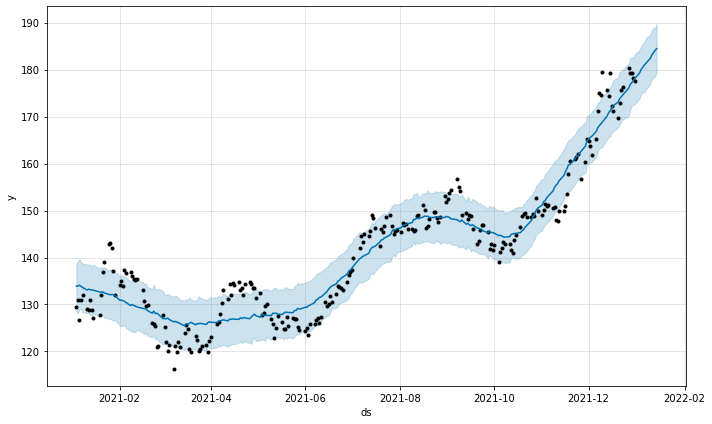

In [38]:
# plot forecast
m.plot(forecast)
pyplot.show()